In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils_notebook import get_logits_targets, modal_probs_decreasing

from collections import OrderedDict, Counter
import random
from typing import Dict


In [39]:
DATA = 'cifar100'
LIKELIHOOD = 'softmax'
EPOCH = 299
# MODELS = ['models_repl', 'models_mono_weights', 'models_mono_weights_5', 'models_mono_penal', 'models_mono_penal_stop_grad', 'models_poe_cascade_stop_grad']

# MODELS = ['models_repl', 'models_mono_weights', 'models_mono_weights_5']
# MODELS_NAMES = ['base', 'mono-weights C=1', 'mono-weights C=5']

MODELS = ['models_repl', 'models_mono_penal', 'models_mono_penal_stop_grad', 'models_mono_penal_3', 'models_mono_penal_5']
MODELS_NAMES = ['base', 'mono-constr-opt C=1', 'mono-constr-opt C=1 w. stop-grad', 'mono-constr-opt C=3', 'mono-constr-opt C=5']

# MODELS = ['models_repl', 'models_poe_cascade_repl', 'models_poe_cascade_stop_grad']
# MODELS_NAMES = ['base', 'PoE-softmax-cascade', 'PoE-softmax-cascade w. stop-grad']

logits_dict = {}
for model_name in MODELS:
    _logits, targets, _ = get_logits_targets(DATA, model_name, LIKELIHOOD, EPOCH, cuda=False, logits_type='test')
    logits_dict[model_name] = _logits

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [40]:
# MODEL_FOLDER = 'models_repl'
# LIKELIHOOD = 'softmax'
# EPOCH = 299


# logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False)

In [41]:
acc_dict, mono_dict = {}, {}
for model_name in MODELS:
    logits = logits_dict[model_name]

    L = len(logits)
    N = len(targets)

    # if 'poe' in model_name:
    #     logits = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
    #     probs = torch.softmax(logits, dim=2)
    #     preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
    # else:
    #     probs = torch.softmax(logits, dim=2)
    #     preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}

    # logits = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
    # probs = torch.softmax(logits, dim=2)
    # preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}

    probs = torch.softmax(logits, dim=2)
    preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}

    acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]

    mono_modal_prob = [round(x, 4) for x in modal_probs_decreasing(preds, probs, layer=L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]
    mono_y_star = [round(x, 4) for x in modal_probs_decreasing(targets, probs, layer=None, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

    print('Model:', model_name)
    print([round(float(x), 4) for x in acc])
    print(mono_modal_prob)
    print(mono_y_star)

    acc_dict[model_name] = acc
    mono_dict[model_name] = modal_probs_decreasing(preds, probs, layer=L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all")

Model: models_repl
[0.632, 0.6566, 0.6772, 0.6993, 0.7125, 0.7206, 0.7207]
[87.72, 69.5, 58.02, 51.77, 43.15, 39.4, 33.99, 23.82]
[87.44, 67.04, 55.09, 48.91, 41.12, 37.82, 33.46, 25.2]
Model: models_mono_penal
[0.476, 0.6224, 0.6639, 0.6794, 0.6965, 0.7113, 0.7126]
[76.43, 61.7, 51.02, 43.97, 36.36, 33.6, 29.44, 22.28]
[76.92, 62.23, 50.04, 43.24, 35.76, 33.33, 30.08, 24.41]
Model: models_mono_penal_stop_grad
[0.5674, 0.6212, 0.6561, 0.6761, 0.6884, 0.6983, 0.7035]
[72.31, 60.28, 52.88, 48.19, 42.64, 40.36, 37.06, 30.63]
[72.16, 59.4, 51.86, 47.35, 42.08, 40.02, 37.06, 31.9]
Model: models_mono_penal_3
[0.0004, 0.632, 0.6511, 0.677, 0.6965, 0.7051, 0.6909]
[79.81, 59.76, 48.34, 42.11, 34.31, 31.42, 27.03, 19.29]
[80.36, 61.25, 50.1, 44.58, 37.54, 35.0, 31.43, 24.94]
Model: models_mono_penal_5
[0.0001, 0.0002, 0.1147, 0.6595, 0.6746, 0.6591, 0.5576]
[94.72, 89.07, 57.55, 44.34, 30.26, 25.31, 18.86, 8.45]
[96.62, 93.44, 73.42, 60.51, 46.15, 41.35, 34.46, 22.22]


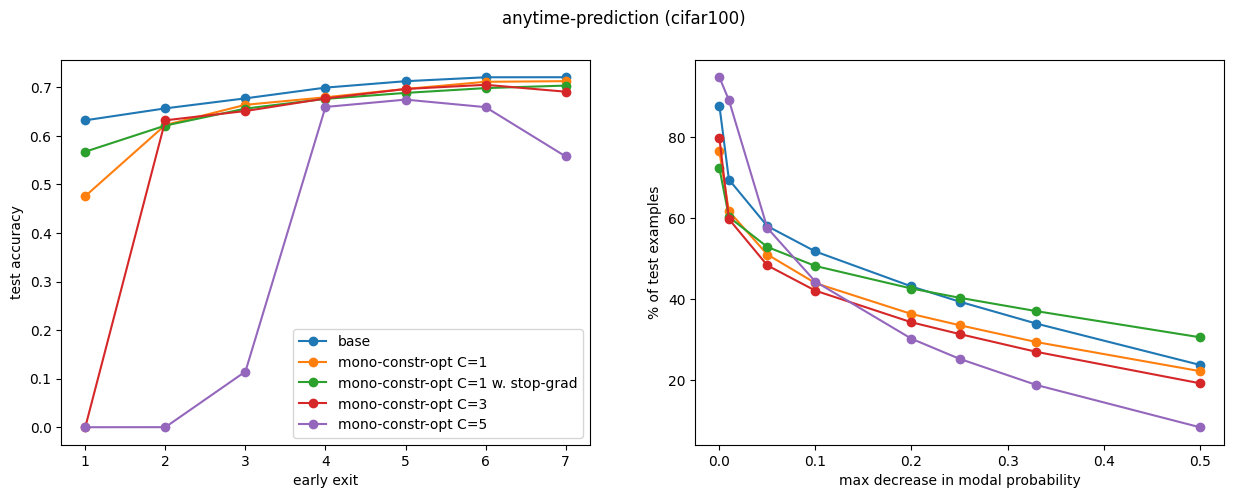

In [42]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for model_name, model_label in zip(MODELS, MODELS_NAMES):
    ax[0].plot(early_exits, acc_dict[model_name], label=model_label, marker='o',)
    ax[1].plot(mono_dict[model_name].keys(), mono_dict[model_name].values(), marker='o', label=model_label)

ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit') 
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples') 
ax[0].legend()

plt.suptitle(f'anytime-prediction ({DATA})')
plt.show()
